In [8]:
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,DenseNet201,ResNet101
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy
import tensorflow as tf
from keras import backend as K
import gc
import json
import itertools
import glob

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
### Path to the dataset
path="/content/drive/Shared drives/BTP_Arya/DATABC_32"

In [ ]:
### Reducing image dimension to fit to RAM
IMG_DIM = (224, 224)

### Using Glob to read the images and then converting into array and then to numpy array
train_files = glob.glob(path+'/train/*')
print(len(train_files))
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
print('Train dataset shape:', train_imgs.shape)

### Using Glob to read the images and then converting into array and then to numpy array
validation_files = glob.glob(path+'/test/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
print('Validation dataset shape:', validation_imgs.shape)

1354
Train dataset shape: (1354, 224, 224, 3)
Validation dataset shape: (659, 224, 224, 3)


In [ ]:
### The images are labelled in their file names,so labels are assigned smartly by seperating '_' using split and checking if it is benign if 'B'
### and 'M' for malignant
train_labels = [fn.split("train/")[1].split("_")[1] for fn in train_files]
validation_labels = [fn.split("test/")[1].split("_")[1] for fn in validation_files]

In [ ]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (224, 224, 3)

### encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[995:1005], train_labels_enc[995:1005])

['B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M'] [0 0 1 0 0 0 1 0 1 1]


In [ ]:
### Randomizing the data.
s = np.arange(train_imgs.shape[0])
np.random.shuffle(s)
train_imgs = train_imgs[s]
train_labels_enc = train_labels_enc[s]

# Shuffle test data
s = np.arange(validation_imgs.shape[0])
np.random.shuffle(s)
validation_imgs = validation_imgs[s]
validation_labels_enc = validation_labels_enc[s]

[0 0 0 1 0 1 1 0 1 1]
1


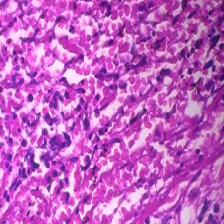

In [ ]:
###Testing
print( train_labels_enc[995:1005])
print(train_labels_enc[0])
array_to_img(train_imgs[0])

(224, 224, 3)


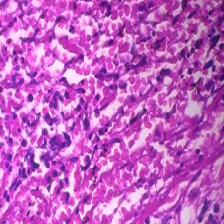

In [ ]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])


In [ ]:
### Creating a Basic CNN model having 4 layers
lr=1e-4
model = Sequential()

model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy'] )

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 86528)            

In [ ]:
###Training
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,validation_data=(validation_imgs_scaled, validation_labels_enc),batch_size=batch_size,epochs=epochs,verbose=1)

Train on 1354 samples, validate on 659 samples
Epoch 1/30
1354/1354 [==============================] - 14s 10ms/step - loss: 0.5693 - accuracy: 0.7290 - val_loss: 0.2885 - val_accuracy: 0.9439
Epoch 2/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4806 - accuracy: 0.8065 - val_loss: 0.3351 - val_accuracy: 0.9302
Epoch 3/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4513 - accuracy: 0.8154 - val_loss: 0.3453 - val_accuracy: 0.9196
Epoch 4/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4335 - accuracy: 0.8183 - val_loss: 0.2588 - val_accuracy: 0.8907
Epoch 5/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4481 - accuracy: 0.8139 - val_loss: 0.2567 - val_accuracy: 0.9317
Epoch 6/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.4124 - accuracy: 0.8390 - val_loss: 0.2345 - val_accuracy: 0.9302
Epoch 7/30
1354/1354 [==============================] - 7s 5ms/step - loss: 0.3976 - ac

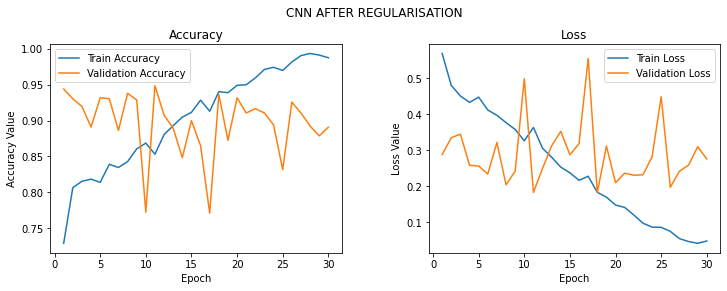

In [ ]:
###Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN AFTER REGULARISATION', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy') ## changed acc to accuracy in history.history
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
### No accuracy has been recorded for the above,as it seems to be a bad model having random features.

In [ ]:
###Using ImageDataGenerator to create generated images by applying various transformations
train_datagen = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=1./255
    )
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=20)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (224, 224, 3)
batch_size=30


In [ ]:
###Training Residual Network ResNet50
lr=1e-4
model = Sequential()
model.add(ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [ ]:
### Saving the extracted numpy arrays of train and test data
np.save("train_imgs.npy", train_imgs)
np.save("train_labels_enc.npy", train_labels_enc)
np.save("validation_imgs.npy", validation_imgs)
np.save("validation_labels_enc.npy", validation_labels_enc)

In [3]:
###loading test and train data
train_labels_enc = np.load("/content/drive/My Drive/train_labels_enc.npy")
train_imgs = np.load("/content/drive/My Drive/train_imgs.npy")
validation_labels_enc = np.load("/content/drive/My Drive/validation_labels_enc.npy")
validation_imgs = np.load("/content/drive/My Drive/validation_imgs.npy")

In [ ]:
#Using checkpoints and ReduceLRonPlateau and training the model
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.05, min_lr=1e-7)
BATCH_SIZE=30
filepath="resnet50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/40
46/45 [==============================] - 58s 1s/step - loss: 0.6719 - accuracy: 0.6859 - val_loss: 4.2074 - val_accuracy: 0.2929

Epoch 00001: val_accuracy improved from -inf to 0.29287, saving model to resnet50.hdf5
Epoch 2/40
46/45 [==============================] - 36s 774ms/step - loss: 0.4465 - accuracy: 0.8009 - val_loss: 1.3978 - val_accuracy: 0.7071

Epoch 00002: val_accuracy improved from 0.29287 to 0.70713, saving model to resnet50.hdf5
Epoch 3/40
46/45 [==============================] - 35s 758ms/step - loss: 0.4043 - accuracy: 0.8348 - val_loss: 2.5724 - val_accuracy: 0.7071

Epoch 00003: val_accuracy did not improve from 0.70713
Epoch 4/40
46/45 [==============================] - 35s 761ms/step - loss: 0.3503 - accuracy: 0.8578 - val_loss: 0.5784 - val_accuracy: 0.7071

Epoch 00004: val_accuracy did not improve from 0.70713
Epoch 5/40
46/45 [==============================] - 35s 761ms/step - loss: 0.3160 - accuracy: 0.8696 - val_loss: 0.7042 - val_accuracy: 0.70

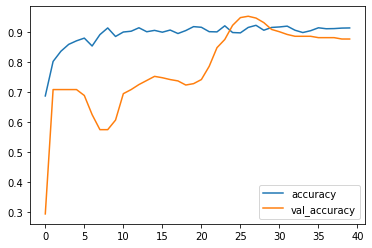

In [ ]:
###saving history in json as a string
with open('history-res50.json', 'w') as f:
    json.dump(str(history.history), f)
###Plotting curve
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [13]:
model.load_weights("/content/drive/Shared drives/BTP_Arya/resnet50.hdf5")
loss,acc = model.evaluate(validation_imgs,  validation_labels_enc, verbose=2)
print("accuracy: {:5.2f}%".format(100*acc))

accuracy: 95.14%


In [ ]:
### ResNet 101 Model
lr=1e-4
model = Sequential()
model.add(ResNet101(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

171450368/171446536 [==============================] - 6s 0us/step


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.33, min_lr=1e-7)
BATCH_SIZE=30
filepath="resnet101.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/30
46/45 [==============================] - 92s 2s/step - loss: 0.6912 - accuracy: 0.6893 - val_loss: 7.0828 - val_accuracy: 0.2929

Epoch 00001: val_accuracy improved from -inf to 0.29287, saving model to resnet101.hdf5
Epoch 2/30
46/45 [==============================] - 54s 1s/step - loss: 0.5102 - accuracy: 0.7891 - val_loss: 1.9056 - val_accuracy: 0.7071

Epoch 00002: val_accuracy improved from 0.29287 to 0.70713, saving model to resnet101.hdf5
Epoch 3/30
46/45 [==============================] - 54s 1s/step - loss: 0.4379 - accuracy: 0.8304 - val_loss: 30.1496 - val_accuracy: 0.7071

Epoch 00003: val_accuracy did not improve from 0.70713
Epoch 4/30
46/45 [==============================] - 55s 1s/step - loss: 0.3608 - accuracy: 0.8598 - val_loss: 6.9715 - val_accuracy: 0.7071

Epoch 00004: val_accuracy did not improve from 0.70713
Epoch 5/30
46/45 [==============================] - 54s 1s/step - loss: 0.3898 - accuracy: 0.8654 - val_loss: 4.7450 - val_accuracy: 0.7071

Epoch

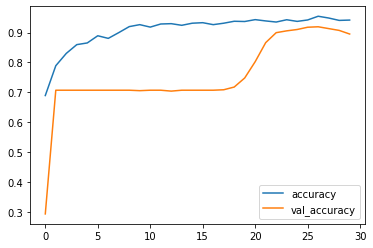

In [ ]:
with open('history-res101.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()


In [11]:
model.load_weights("/content/drive/Shared drives/BTP_Arya/resnet101.hdf5")
loss,acc = model.evaluate(validation_imgs,  validation_labels_enc, verbose=2)
print("accuracy: {:5.2f}%".format(100*acc))

accuracy: 91.96%


In [ ]:
### Densenet201 model
model = Sequential()
model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
###Training with checkpoints
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.2, min_lr=1e-7)

filepath="best-densenet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/40
46/45 [==============================] - 90s 2s/step - loss: 0.2595 - accuracy: 0.8928 - val_loss: 0.6659 - val_accuracy: 0.8376

Epoch 00001: val_accuracy improved from -inf to 0.83763, saving model to best-densenet.hdf5
Epoch 2/40
46/45 [==============================] - 90s 2s/step - loss: 0.2498 - accuracy: 0.8913 - val_loss: 0.8872 - val_accuracy: 0.8892

Epoch 00002: val_accuracy improved from 0.83763 to 0.88923, saving model to best-densenet.hdf5
Epoch 3/40
46/45 [==============================] - 90s 2s/step - loss: 0.1900 - accuracy: 0.9168 - val_loss: 0.1838 - val_accuracy: 0.8998

Epoch 00003: val_accuracy improved from 0.88923 to 0.89985, saving model to best-densenet.hdf5
Epoch 4/40
46/45 [==============================] - 90s 2s/step - loss: 0.2225 - accuracy: 0.9136 - val_loss: 0.2715 - val_accuracy: 0.9302

Epoch 00004: val_accuracy improved from 0.89985 to 0.93020, saving model to best-densenet.hdf5
Epoch 5/40
46/45 [==============================] - 90s 2s/

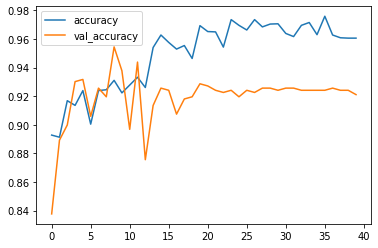

In [ ]:
###Plotting curves
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [10]:
model.load_weights("/content/drive/Shared drives/BTP_Arya/best-densenet.hdf5")
loss,acc = model.evaluate(validation_imgs,  validation_labels_enc, verbose=2)
print("accuracy: {:5.2f}%".format(100*acc))

accuracy: 95.45%


In [ ]:
###loading model with weights
lr=1e-4
model = Sequential()
model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
model.load_weights("best-densenet.hdf5")

In [18]:
###installing spams to implement Stain normalisation
!pip install spams

     |████████████████████████████████| 1.9MB 2.8MB/s 
  Created wheel for spams: filename=spams-2.6.1-cp36-cp36m-linux_x86_64.whl size=4512879 sha256=8ec1513e35a1dd232fbf4beb8d985a5e00c1c69f713ef72f51fad4986c450ab5
  Stored in directory: /root/.cache/pip/wheels/76/a6/a8/5959872693a82d5497a91aee3665bb1676cee33304d86c1495
Successfully built spams


In [19]:
### Stain Normalisation Implementation,this code is copied from kaggle.

import spams
class TissueMaskException(Exception):
    pass

######################################################################################################

def is_uint8_image(I):

    if not is_image(I):
        return False
    if I.dtype != np.uint8:
        return False
    return True
######################################################################################################

def is_image(I):

    if not isinstance(I, np.ndarray):
        return False
    if not I.ndim == 3:
        return False
    return True
######################################################################################################

def get_tissue_mask(I, luminosity_threshold=0.8):

    I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
    L = I_LAB[:, :, 0] / 255.0  # Convert to range [0,1].
    mask = L < luminosity_threshold

    # Check it's not empty
    if mask.sum() == 0:
        raise TissueMaskException("Empty tissue mask computed")

    return mask

######################################################################################################

def convert_RGB_to_OD(I):

    mask = (I == 0)
    I[mask] = 1
    

    #return np.maximum(-1 * np.log(I / 255), 1e-6)
    return np.maximum(-1 * np.log(I / 255), np.zeros(I.shape) + 0.1)

######################################################################################################

def convert_OD_to_RGB(OD):

    assert OD.min() >= 0, "Negative optical density."
    
    OD = np.maximum(OD, 1e-6)
    
    return (255 * np.exp(-1 * OD)).astype(np.uint8)

######################################################################################################

def normalize_matrix_rows(A):

    return A / np.linalg.norm(A, axis=1)[:, None]

######################################################################################################


def get_concentrations(I, stain_matrix, regularizer=0.01):

    OD = convert_RGB_to_OD(I).reshape((-1, 3))
    return spams.lasso(X=OD.T, D=stain_matrix.T, mode=2, lambda1=regularizer, pos=True).toarray().T

######################################################################################################

def get_stain_matrix(I, luminosity_threshold=0.8, angular_percentile=99):
    
    #assert is_uint8_image(I), "Image should be RGB uint8."
    # Convert to OD and ignore background
    tissue_mask = get_tissue_mask(I, luminosity_threshold=luminosity_threshold).reshape((-1,))
    OD = convert_RGB_to_OD(I).reshape((-1, 3))
    
    OD = OD[tissue_mask]

    # Eigenvectors of cov in OD space (orthogonal as cov symmetric)
    _, V = np.linalg.eigh(np.cov(OD, rowvar=False))

    # The two principle eigenvectors
    V = V[:, [2, 1]]

    # Make sure vectors are pointing the right way
    if V[0, 0] < 0: V[:, 0] *= -1
    if V[0, 1] < 0: V[:, 1] *= -1

    # Project on this basis.
    That = np.dot(OD, V)

    # Angular coordinates with repect to the prinicple, orthogonal eigenvectors
    phi = np.arctan2(That[:, 1], That[:, 0])

    # Min and max angles
    minPhi = np.percentile(phi, 100 - angular_percentile)
    maxPhi = np.percentile(phi, angular_percentile)

    # the two principle colors
    v1 = np.dot(V, np.array([np.cos(minPhi), np.sin(minPhi)]))
    v2 = np.dot(V, np.array([np.cos(maxPhi), np.sin(maxPhi)]))

    # Order of H and E.
    # H first row.
    if v1[0] > v2[0]:
        HE = np.array([v1, v2])
    else:
        HE = np.array([v2, v1])

    return normalize_matrix_rows(HE)

######################################################################################################

def mapping(target,source):
    
    stain_matrix_target = get_stain_matrix(target)
    target_concentrations = get_concentrations(target,stain_matrix_target)
    maxC_target = np.percentile(target_concentrations, 99, axis=0).reshape((1, 2))
    stain_matrix_target_RGB = convert_OD_to_RGB(stain_matrix_target) 
    
    stain_matrix_source = get_stain_matrix(source)
    source_concentrations = get_concentrations(source, stain_matrix_source)
    maxC_source = np.percentile(source_concentrations, 99, axis=0).reshape((1, 2))
    source_concentrations *= (maxC_target / maxC_source)
    tmp = 255 * np.exp(-1 * np.dot(source_concentrations, stain_matrix_target))
    return tmp.reshape(source.shape).astype(np.uint8)

In [20]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
# target = cv.imread(validation_files[108])
# source = cv.imread(train_files[555])
target = validation_imgs[108]
source = train_imgs[555]

# Convert from cv2 standard of BGR to our convention of RGB.
target = cv.cvtColor(target, cv.COLOR_BGR2RGB)
source = cv.cvtColor(source, cv.COLOR_BGR2RGB)

# Perform stain normalization
transformed = mapping(target,source)


In [ ]:
### Transforming the whole datasets and storing it into another numpy array
trans_train_imgs=[]
cnt=0
for i in train_imgs:
  source = i
  target = train_imgs[555]
  target = cv.cvtColor(target, cv.COLOR_BGR2RGB)
  source = cv.cvtColor(source, cv.COLOR_BGR2RGB)
  transformed = mapping(target,source)
  trans_train_imgs.append(transformed)
transformed_train_imgs=np.array(trans_train_imgs)


trans_val_imgs=[]

for i in validation_imgs:
  source = i
  target = train_imgs[555]
  target = cv.cvtColor(target, cv.COLOR_BGR2RGB)
  source = cv.cvtColor(source, cv.COLOR_BGR2RGB)
  transformed = mapping(target,source)
  trans_val_imgs.append(transformed)

transformed_validation_imgs=np.array(trans_val_imgs)

(1354, 224, 224, 3)
(659, 224, 224, 3)


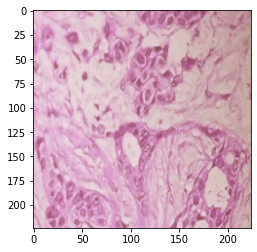

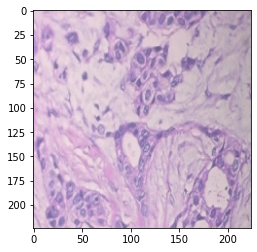

In [22]:
###testing
print(transformed_train_imgs.shape)
print(transformed_validation_imgs.shape)
plt.imshow(transformed_train_imgs[220])
plt.show()
plt.imshow(train_imgs.astype(np.uint8)[220])
plt.show()

In [ ]:
### saving the stain normalised images
np.save("transformed_validation_imgs.npy", transformed_validation_imgs)
np.save("transformed_train_imgs.npy", transformed_train_imgs)

Text(0.5, 1.0, 'Transformed Image')

<Figure size 432x288 with 0 Axes>

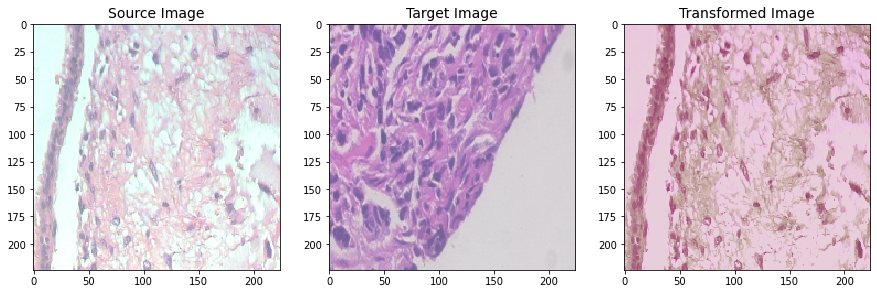

In [25]:
### examples
fig = plt.figure()
fig, ax = plt.subplots(1,3, figsize=(15,15))

ax[0].imshow(train_imgs[4].astype(np.uint8),interpolation='nearest')
ax[0].set_title("Source Image",fontsize=14)
ax[1].imshow(train_imgs[555].astype(np.uint8),interpolation='nearest')
ax[1].set_title("Target Image",fontsize=14)
ax[2].imshow(transformed_train_imgs[4].astype(np.uint8),interpolation='nearest')
ax[2].set_title("Transformed Image",fontsize=14)

In [3]:
###loading the transformed images
transformed_validation_imgs = np.load("/content/drive/My Drive/transformed_validation_imgs.npy")
transformed_train_imgs = np.load("/content/drive/My Drive/transformed_train_imgs.npy")
train_labels_enc = np.load("/content/drive/My Drive/train_labels_enc.npy")
validation_labels_enc = np.load("/content/drive/My Drive/validation_labels_enc.npy")

In [4]:
###image generator
train_datagen = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=1./255
    )
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(transformed_train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(transformed_validation_imgs, validation_labels_enc, batch_size=30)
input_shape = (224, 224, 3)
batch_size=30


In [5]:
###Densenet201 Model
lr=1e-4
model = Sequential()
model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))

model.add(layers.BatchNormalization())
# model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))    
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

74842112/74836368 [==============================] - 3s 0us/step


In [ ]:

lr=1e-4
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.33, min_lr=1e-7)
BATCH_SIZE=30
filepath="densenet201tr.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_imgs.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint],verbose=1
)

Epoch 1/40
46/45 [==============================] - 140s 3s/step - loss: 0.6848 - accuracy: 0.6189 - val_loss: 0.4275 - val_accuracy: 0.8103

Epoch 00001: val_accuracy improved from -inf to 0.81032, saving model to densenet201tr.h5
Epoch 2/40
46/45 [==============================] - 46s 1s/step - loss: 0.5726 - accuracy: 0.7170 - val_loss: 0.6156 - val_accuracy: 0.7390

Epoch 00002: val_accuracy did not improve from 0.81032
Epoch 3/40
46/45 [==============================] - 46s 1s/step - loss: 0.4678 - accuracy: 0.7784 - val_loss: 0.7786 - val_accuracy: 0.7390

Epoch 00003: val_accuracy did not improve from 0.81032
Epoch 4/40
46/45 [==============================] - 46s 1s/step - loss: 0.4286 - accuracy: 0.8162 - val_loss: 0.2800 - val_accuracy: 0.7876

Epoch 00004: val_accuracy did not improve from 0.81032
Epoch 5/40
46/45 [==============================] - 46s 1s/step - loss: 0.3865 - accuracy: 0.8277 - val_loss: 0.4353 - val_accuracy: 0.8134

Epoch 00005: val_accuracy improved from

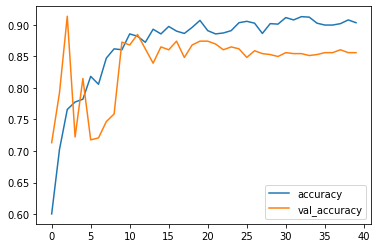

In [ ]:
###plot of stain normalised densenet 201 model
with open('history-densenettr.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)

history_df[['accuracy', 'val_accuracy']].plot()

In [9]:
model.load_weights("/content/drive/Shared drives/BTP_Arya/densenet201tr.h5")
loss,acc = model.evaluate(transformed_validation_imgs,  validation_labels_enc, verbose=2)
print("accuracy: {:5.2f}%".format(100*acc))

accuracy: 93.47%


In [22]:
K.clear_session
gc.collect

<function gc.collect>